# Carregando Dados Experimentais

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.signal import resample

In [2]:
def extract_data(path, files, skip_rows):
    df = pd.concat((pd.read_csv(path + files[f] + '.csv', skiprows=[i for i in range(1, skip_rows)]).assign(filename=f) for f in range(len(files))), ignore_index=True)
    df.columns.values[:] = ['Va', 'Vb', 'Vc', 'Ia', 'Ib', 'Ic', 'label']

    return df

In [3]:
files =  ['struct_rs_R1.mat_torque05', 'struct_rs_R1.mat_torque10', 'struct_rs_R1.mat_torque15', 'struct_rs_R1.mat_torque20', 'struct_rs_R1.mat_torque25','struct_rs_R1.mat_torque30', 'struct_rs_R1.mat_torque35', 'struct_rs_R1.mat_torque40', 
          'struct_r1b_R1.mat_torque05', 'struct_r1b_R1.mat_torque10', 'struct_r1b_R1.mat_torque15', 'struct_r1b_R1.mat_torque20', 'struct_r1b_R1.mat_torque25','struct_r1b_R1.mat_torque30', 'struct_r1b_R1.mat_torque35', 'struct_r1b_R1.mat_torque40',
          'struct_r2b_R1.mat_torque05', 'struct_r2b_R1.mat_torque10', 'struct_r2b_R1.mat_torque15', 'struct_r2b_R1.mat_torque20', 'struct_r2b_R1.mat_torque25','struct_r2b_R1.mat_torque30', 'struct_r2b_R1.mat_torque35', 'struct_r2b_R1.mat_torque40',
          'struct_r3b_R1.mat_torque05', 'struct_r3b_R1.mat_torque10', 'struct_r3b_R1.mat_torque15', 'struct_r3b_R1.mat_torque20', 'struct_r3b_R1.mat_torque25','struct_r3b_R1.mat_torque30', 'struct_r3b_R1.mat_torque35', 'struct_r3b_R1.mat_torque40',
          'struct_r4b_R1.mat_torque05', 'struct_r4b_R1.mat_torque10', 'struct_r4b_R1.mat_torque15', 'struct_r2b_R1.mat_torque20', 'struct_r2b_R1.mat_torque25','struct_r2b_R1.mat_torque30', 'struct_r2b_R1.mat_torque35', 'struct_r2b_R1.mat_torque40']
path = 'C:/Users/vinic/Desktop/LXL/USP/Dataset_USP_CSV/'


df = extract_data(path=path, files=files, skip_rows=194657)


# Resample 833 pontos por ciclo para 128

df0 = np.array(np.concatenate([np.array_split(np.array(df.iloc[:, 3]).reshape(968*40, 833), 40)[i] for i in range(40)], axis=0))
df0 = np.concatenate([resample(df0[i], 128).reshape(1, -1) for i in range(df0.shape[0])], axis=0)

df1 = np.array(np.concatenate([np.array_split(np.array(df.iloc[:, 4]).reshape(968*40, 833), 40)[i] for i in range(40)], axis=0))
df1 = np.concatenate([resample(df1[i], 128).reshape(1, -1) for i in range(df1.shape[0])], axis=0)

df2 = np.array(np.concatenate([np.array_split(np.array(df.iloc[:, 5]).reshape(968*40, 833), 40)[i] for i in range(40)], axis=0))
df2 = np.concatenate([resample(df2[i], 128).reshape(1, -1) for i in range(df2.shape[0])], axis=0)


# Concatena todos os valores extraidos em uma unica matriz
datasetCon = np.concatenate((df0, df1, df2), axis=1)

# Adiciona os Labels
labels = np.concatenate([np.full((968, 1), i, dtype=int) for i in range(40)], axis=0)

datasetCon = np.concatenate((datasetCon, labels),axis=1)

# Treino, Teste e Validação

In [4]:
""" Aplicando one-hot-encoding, as categorias se transformam em colunas (variáveis) onde o 
número 1 representa o valor afirmativo e o 0 negativo. 
https://arthurlambletvaz.medium.com/one-hot-encoding-o-que-%C3%A9-cd2e8d302ae0 """

"""60% - Treino, 20% - Validação, 20% - Teste"""

# Coleta os dados das entradas datasetCon (ficando de fora os dados do One-hot-encoder)
x_datasetCon = datasetCon[:, :-1]

# Coleta os dados das saídas
y_datasetCon = datasetCon[:, -1]

# Separa os dados de entrada e saida para treino e testes
x_train,x_temp,y_train,y_temp = train_test_split(x_datasetCon,y_datasetCon, test_size=0.3, random_state=42, shuffle=True, stratify=y_datasetCon)
x_test,x_validation,y_test,y_validation = train_test_split(x_temp,y_temp, test_size=0.5, random_state=42, shuffle=True, stratify=y_temp)



"""Tamanho do teste e Validação (X, Y)"""

# Treino
print(x_train.shape, y_train.shape)

# Validação
print(x_validation.shape, y_validation.shape)

# Test
print(x_test.shape, y_test.shape)

"""Normalização"""

scaler  = MinMaxScaler(feature_range=(0,1)) # Tangente Hiperbólica ou outro análoga

x_train       = scaler.fit_transform(x_train)
x_validation  = scaler.fit_transform(x_validation)
x_test        = scaler.fit_transform(x_test)

(27104, 384) (27104,)
(5808, 384) (5808,)
(5808, 384) (5808,)


In [5]:
## Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Conv1D, SpatialDropout1D, Dropout, MaxPooling1D, BatchNormalization, Dense, Flatten, LSTM, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2, L1L2
from tensorflow.keras.constraints import unit_norm

# Optuna

In [6]:
import optuna

c:\Users\vinic\.conda\envs\tensorflow\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
class Objective(object):
    def __init__(self, max_epochs):
        self.max_epochs = max_epochs
 
    def __call__(self, trial):        
        num_cnn_blocks = trial.suggest_int('num_cnn_blocks', 2, 5) # Define o range de camadas convolucionais que podem ser utilizadas
        num_dense_blocks = trial.suggest_int('num_dense_blocks', 2, 5) # Define o range de camadas densas que podem ser utilizadas
        
        # Número de filtros em cada Camada Convolucional
        num_filters = trial.suggest_categorical('num_filters', [16, 32, 48, 64])
        num_filters_0 = trial.suggest_categorical('num_filters_0', [16, 32, 48, 64])
        num_filters_1 = trial.suggest_categorical('num_filters_1', [16, 32, 48, 64])
        num_filters_2 = trial.suggest_categorical('num_filters_2', [16, 32, 48, 64])
        num_filters_3 = trial.suggest_categorical('num_filters_3', [16, 32, 48, 64])


        kernel_size = trial.suggest_int('kernel_size', 2, 16, step=2) # Tamanho do Kernel (filtro)
       
        # Número de neurônios em cada Camada Densa
        num_dense_nodes = trial.suggest_categorical('num_dense_nodes', [64, 128, 512, 1024])
        num_dense_nodes_0 = trial.suggest_categorical('num_dense_nodes_0', [64, 128, 512, 1024])
        num_dense_nodes_1 = trial.suggest_categorical('num_dense_nodes_1', [64, 128, 512, 1024])
        num_dense_nodes_2 = trial.suggest_categorical('num_dense_nodes_2', [64, 128, 512, 1024])
        num_dense_nodes_3 = trial.suggest_categorical('num_dense_nodes_3', [64, 128, 512, 1024])
       
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 96, 128]) # Batch Size
       
        drop_out=trial.suggest_float('drop_out', 0.0, 0.5, step=0.05, log=False) # Dropout

        kernel_regularizer_l1 = trial.suggest_float('kernel_regularizer_l1', 5e-6, 1e-4, log=True) # Regularizador
        kernel_regularizer_l2 = 1e-4

        lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True) # Learning Rate


                          
        dict_params = {'num_cnn_blocks':num_cnn_blocks,
                       'num_dense_blocks':num_dense_blocks,
                       
                       'num_filters':num_filters,
                       'num_filters_0':num_filters_0,
                       'num_filters_1':num_filters_1,
                       'num_filters_2':num_filters_2,
                       'num_filters_3':num_filters_3,

                       'kernel_size':kernel_size,

                       'num_dense_nodes':num_dense_nodes,
                       'num_dense_nodes_0':num_dense_nodes_0,
                       'num_dense_nodes_1':num_dense_nodes_1,
                       'num_dense_nodes_2':num_dense_nodes_2,
                       'num_dense_nodes_3':num_dense_nodes_3,

                       'batch_size':batch_size,
                       'drop_out':drop_out,
                       'kernel_regularizer_l1':kernel_regularizer_l1,
                       
                       'lr':lr}
                                              
        # Começo da CNN
        inputs = Input((x_train.shape[1],1))
         
        # Primeiro camada convolucional
        Conv = Conv1D(filters=dict_params['num_filters'], 
                    kernel_size=dict_params['kernel_size'], 
                    strides=1, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=L1L2(l1=kernel_regularizer_l1, l2=kernel_regularizer_l2),
                    bias_regularizer=L1L2(l1=1e-4, l2=1e-3))(inputs)

        Conv = keras.layers.SpatialDropout1D(dict_params['drop_out'])(Conv)
        Conv = MaxPooling1D(pool_size=3, strides=None, padding='same')(Conv)
        Conv = BatchNormalization()(Conv)
         
        # Camadas convolucionais adicionais
        for iblock in range(dict_params['num_cnn_blocks'] - 1):
            Conv = Conv1D(filters=dict_params['num_filters_'+str(iblock)], 
                        kernel_size=dict_params['kernel_size'], 
                        strides=1, 
                        activation='relu', 
                        padding='same', 
                        kernel_regularizer=L1L2(l1=kernel_regularizer_l1, l2=kernel_regularizer_l2),
                        bias_regularizer=L1L2(l1=1e-4, l2=1e-3))(Conv)

            Conv = keras.layers.SpatialDropout1D(dict_params['drop_out'])(Conv)
            Conv = MaxPooling1D(pool_size=3, strides=None, padding='same')(Conv)
            Conv = BatchNormalization()(Conv)
                         
        # Flatten
        dense = Flatten()(Conv)
        
        # Primeira camada densa
        dense = Dense(units=dict_params['num_dense_nodes'], 
                    activation='relu',
                    kernel_regularizer=L1L2(l1=kernel_regularizer_l1, l2=kernel_regularizer_l2),
                    bias_regularizer=L1L2(l1=1e-4, l2=1e-3),
                    activity_regularizer=L1L2(l1=1e-4, l2=1e-3))(dense)
        dense = keras.layers.Dropout(dict_params['drop_out'])(dense)


        # Camadas densas adicionais
        for iblock in range(dict_params['num_dense_blocks'] - 1):
            dense = Dense(units=dict_params['num_dense_nodes_'+str(iblock)], 
                        activation='relu',
                        kernel_regularizer=L1L2(l1=kernel_regularizer_l1, l2=kernel_regularizer_l2),
                        bias_regularizer=L1L2(l1=1e-4, l2=1e-3),
                        activity_regularizer=L1L2(l1=1e-4, l2=1e-3))(dense)
            dense = keras.layers.Dropout(dict_params['drop_out'])(dense)
        
        # Camda de saída
        dense = Dense(len(pd.DataFrame(y_test).value_counts()), activation='softmax')(dense)
         
        
        
        # instantiate and compile model
        model = Model(inputs, dense)
        opt = Adam(learning_rate = lr)


        model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['acc'])
        


        """ Callbacks """

        # Check Point
        checkpoint_cb = ModelCheckpoint('CNN_Optuna.h5', save_best_only=True, monitor='val_acc', mode='auto')

        # Early Stopping
        earlystopping = EarlyStopping(monitor="val_acc", min_delta=1e-3, patience=15, mode='auto', restore_best_weights=True)

        # Reduce LR
        reduceLR = ReduceLROnPlateau(monitor="val_acc", factor=0.8, patience=10, mode="auto", min_delta=1e-3, cooldown=0, min_lr=0)

             
        # fit the model
        history = model.fit(x_train, y_train, epochs=self.max_epochs,
                            validation_data=(x_validation, y_validation),
                            batch_size=batch_size, 
                            callbacks=[[checkpoint_cb, earlystopping, reduceLR]])
                 
        # Evaluate the model accuracy on the test set.
        score = model.evaluate(x_test, y_test)
                 
        return score[1]

In [8]:
maximum_epochs = 80

maximum_time = 28*60*60  # seconds
 
objective = Objective(maximum_epochs)
 
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
 
study.optimize(objective, timeout=maximum_time)
 
# save results
df_results = study.trials_dataframe()

trial_CNN = study.best_trial

print('CC: {}'.format(trial_CNN.value))
print("Best hyperparameters: {}".format(trial_CNN.params))

Epoch 1/80
847/847 [==============================] - 35s 39ms/step - loss: 6.7299 - acc: 0.0957 - val_loss: 4.4409 - val_acc: 0.2853 - lr: 1.4530e-04
Epoch 2/80
847/847 [==============================] - 35s 42ms/step - loss: 3.6610 - acc: 0.2421 - val_loss: 2.8717 - val_acc: 0.3657 - lr: 1.4530e-04
Epoch 3/80
847/847 [==============================] - 36s 42ms/step - loss: 2.8499 - acc: 0.3111 - val_loss: 2.5005 - val_acc: 0.3819 - lr: 1.4530e-04
Epoch 4/80
847/847 [==============================] - 36s 42ms/step - loss: 2.5460 - acc: 0.3509 - val_loss: 2.2366 - val_acc: 0.4273 - lr: 1.4530e-04
Epoch 5/80
847/847 [==============================] - 35s 42ms/step - loss: 2.3629 - acc: 0.3782 - val_loss: 2.0827 - val_acc: 0.4640 - lr: 1.4530e-04
Epoch 6/80
847/847 [==============================] - 36s 42ms/step - loss: 2.2177 - acc: 0.4051 - val_loss: 1.9938 - val_acc: 0.4831 - lr: 1.4530e-04
Epoch 7/80
847/847 [==============================] - 35s 42ms/step - loss: 2.1265 - acc: 0.42

In [9]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial_CNN

print("  Value: ", trial_CNN.value)

print("  Params: ")
for key, value in trial_CNN.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  49
Best trial:
  Value:  0.8369490504264832
  Params: 
    num_cnn_blocks: 3
    num_dense_blocks: 2
    num_filters: 32
    num_filters_0: 32
    num_filters_1: 32
    num_filters_2: 48
    num_filters_3: 48
    kernel_size: 6
    num_dense_nodes: 512
    num_dense_nodes_0: 64
    num_dense_nodes_1: 64
    num_dense_nodes_2: 1024
    num_dense_nodes_3: 1024
    batch_size: 96
    drop_out: 0.05
    kernel_regularizer_l1: 2.41269822866135e-05
    lr: 0.0007522788572365815


In [10]:
optuna.visualization.plot_optimization_history(study)

In [11]:
optuna.visualization.plot_slice(study)

In [12]:
optuna.visualization.plot_param_importances(study)

# Teste

In [6]:
# Começo da CNN
inputs = Input((x_train.shape[1],1))
    
# Primeira camada convolucional
Conv = Conv1D(filters=32, 
            kernel_size=6, 
            strides=1, 
            activation='relu', 
            padding='same', 
            kernel_regularizer=L1L2(l1=2.4e-5, l2=1e-3),
            bias_regularizer=L1L2(l1=1e-4, l2=1e-3))(inputs)

Conv = keras.layers.SpatialDropout1D(0.05)(Conv)
Conv = MaxPooling1D(pool_size=3, strides=None, padding='same')(Conv)
Conv = BatchNormalization()(Conv)
    
# Segunda camada convolucional
Conv = Conv1D(filters=32, 
            kernel_size=6, 
            strides=1, 
            activation='relu', 
            padding='same', 
            kernel_regularizer=L1L2(l1=2.4e-5, l2=1e-3),
            bias_regularizer=L1L2(l1=1e-4, l2=1e-3))(Conv)

Conv = keras.layers.SpatialDropout1D(0.05)(Conv)
Conv = MaxPooling1D(pool_size=3, strides=None, padding='same')(Conv)
Conv = BatchNormalization()(Conv)


# Terceira camada convolucional
Conv = Conv1D(filters=32, 
            kernel_size=6, 
            strides=1, 
            activation='relu', 
            padding='same', 
            kernel_regularizer=L1L2(l1=2.4e-5, l2=1e-3),
            bias_regularizer=L1L2(l1=1e-4, l2=1e-3))(Conv)

Conv = keras.layers.SpatialDropout1D(0.05)(Conv)
Conv = MaxPooling1D(pool_size=3, strides=None, padding='same')(Conv)
Conv = BatchNormalization()(Conv)
                    
# Flatten
dense = Flatten()(Conv)

# Primeira camada densa
dense = Dense(units=512, 
            activation='relu',
            kernel_regularizer=L1L2(l1=2.4e-5, l2=1e-3),
            bias_regularizer=L1L2(l1=1e-4, l2=1e-3),
            activity_regularizer=L1L2(l1=1e-4, l2=1e-3))(dense)
dense = keras.layers.Dropout(0.05)(dense)


# Segunda camada densa
dense = Dense(units=64, 
            activation='relu',
            kernel_regularizer=L1L2(l1=2.4e-5, l2=1e-3),
            bias_regularizer=L1L2(l1=1e-4, l2=1e-3),
            activity_regularizer=L1L2(l1=1e-4, l2=1e-3))(dense)
dense = keras.layers.Dropout(0.05)(dense)



# Camda de saída
dense = Dense(len(pd.DataFrame(y_test).value_counts()), activation='softmax')(dense)
    


# instantiate and compile model
model = Model(inputs, dense)
opt = Adam(learning_rate = 0.000752)


model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['acc'])



""" Callbacks """

# Check Point
checkpoint_cb = ModelCheckpoint('CNN_Optuna.h5', save_best_only=True, monitor='val_acc', mode='auto')

# Early Stopping
earlystopping = EarlyStopping(monitor="val_acc", min_delta=1e-3, patience=50, mode='auto', restore_best_weights=True)

# Reduce LR
reduceLR = ReduceLROnPlateau(monitor="val_acc", factor=0.8, patience=20, mode="auto", min_delta=1e-3, cooldown=0, min_lr=0)

        
# fit the model
history = model.fit(x_train, y_train, epochs=300,
                    validation_data=(x_validation, y_validation),
                    batch_size=64, 
                    callbacks=[[checkpoint_cb, earlystopping, reduceLR]])
            
# Evaluate the model accuracy on the test set.
score = model.evaluate(x_test, y_test)
            

Epoch 1/300
424/424 [==============================] - 14s 29ms/step - loss: 3.1849 - acc: 0.2847 - val_loss: 9.5020 - val_acc: 0.0250 - lr: 7.5200e-04
Epoch 2/300
424/424 [==============================] - 12s 28ms/step - loss: 2.1545 - acc: 0.4345 - val_loss: 1.7579 - val_acc: 0.5506 - lr: 7.5200e-04
Epoch 3/300
424/424 [==============================] - 12s 28ms/step - loss: 1.6947 - acc: 0.5228 - val_loss: 1.4885 - val_acc: 0.5851 - lr: 7.5200e-04
Epoch 4/300
424/424 [==============================] - 12s 28ms/step - loss: 1.4584 - acc: 0.5731 - val_loss: 1.3461 - val_acc: 0.5995 - lr: 7.5200e-04
Epoch 5/300
424/424 [==============================] - 12s 27ms/step - loss: 1.3148 - acc: 0.6078 - val_loss: 1.3357 - val_acc: 0.5775 - lr: 7.5200e-04
Epoch 6/300
424/424 [==============================] - 12s 27ms/step - loss: 1.1987 - acc: 0.6441 - val_loss: 1.3507 - val_acc: 0.5856 - lr: 7.5200e-04
Epoch 7/300
424/424 [==============================] - 12s 28ms/step - loss: 1.1198 - ac

In [7]:
# **Função para salvar plot**
def plot_loss_acc(history,more_title='', nameLoss="Loss", nameAccuracy="Accuracy"):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, loss, 'r', label='Treino loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Loss Treino e Validação' + ' ' + more_title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    #plt.savefig(nameLoss+".png", format='png')
    plt.show()

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    plt.figure(figsize=(8,5))
    plt.plot(epochs, acc, 'r', label='Treino acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Accuracy Treino e Validação' + ' ' + more_title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #plt.savefig(nameAccuracy+".png", format='png')
    plt.show()

    print(more_title + 'Accuracy Treino: {:.3f} %, Accuracy Validação: {:.2f} %'.format(acc[len(acc)-1] *100, val_acc[len(val_acc)-1]*100))
    print(more_title + 'Loss Treino: {:.3f} %, Loss Validação: {:.2f} %'.format(loss[len(loss)-1] *100, val_loss[len(val_loss)-1]*100))

    return loss, val_loss, acc, val_acc

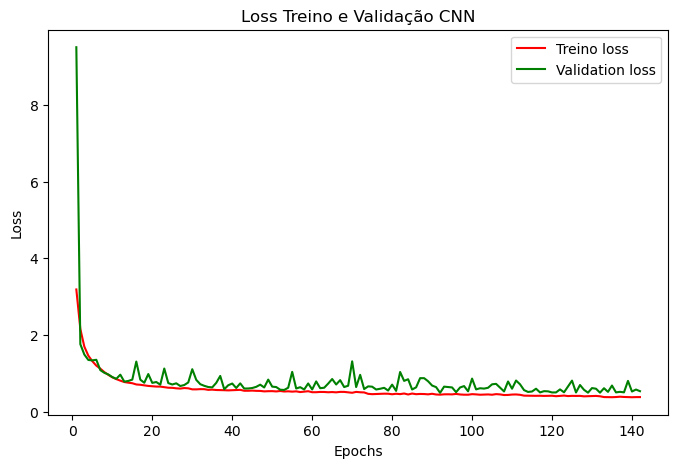

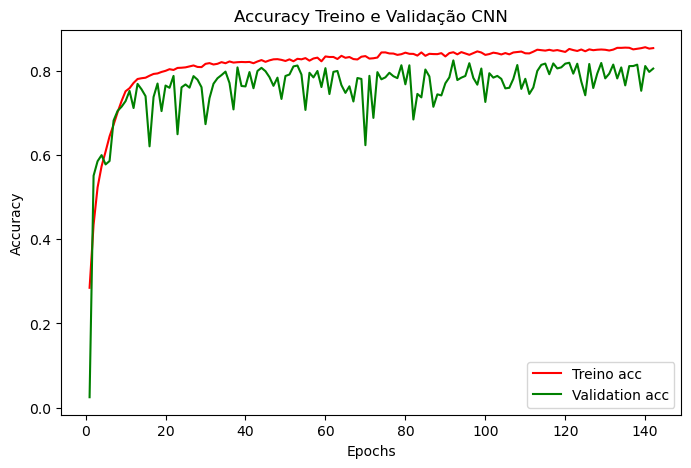

CNNAccuracy Treino: 85.349 %, Accuracy Validação: 80.49 %
CNNLoss Treino: 37.809 %, Loss Validação: 53.23 %


In [8]:
# **Plot com salvamento graficos**
loss, val_loss, acc, val_acc = plot_loss_acc(history,'CNN')

In [9]:
# **Validação da base de teste**
saida_rede = pd.DataFrame(model.predict(x_test)).round(decimals = 2)

display(saida_rede)

182/182 [==============================] - 1s 5ms/step


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.99,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
1,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.00
2,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.95,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.02
3,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
4,1.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5803,1.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
5804,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.5,0.00,0.00
5805,0.00,0.0,0.0,0.0,0.0,0.0,0.42,0.0,0.0,0.0,...,0.15,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.00
5806,0.64,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00


In [10]:
# **Acerto da rede**
predito   = saida_rede.idxmax(axis=1)
avaliado  = pd.DataFrame(y_test).iloc[:, 0]

resultado = list(avaliado.values - predito.values)
resultado = resultado.count(0) * 100 / len(resultado)

print("Porcentagem de acerto {}%".format(int(resultado)))

Porcentagem de acerto 81%


[]

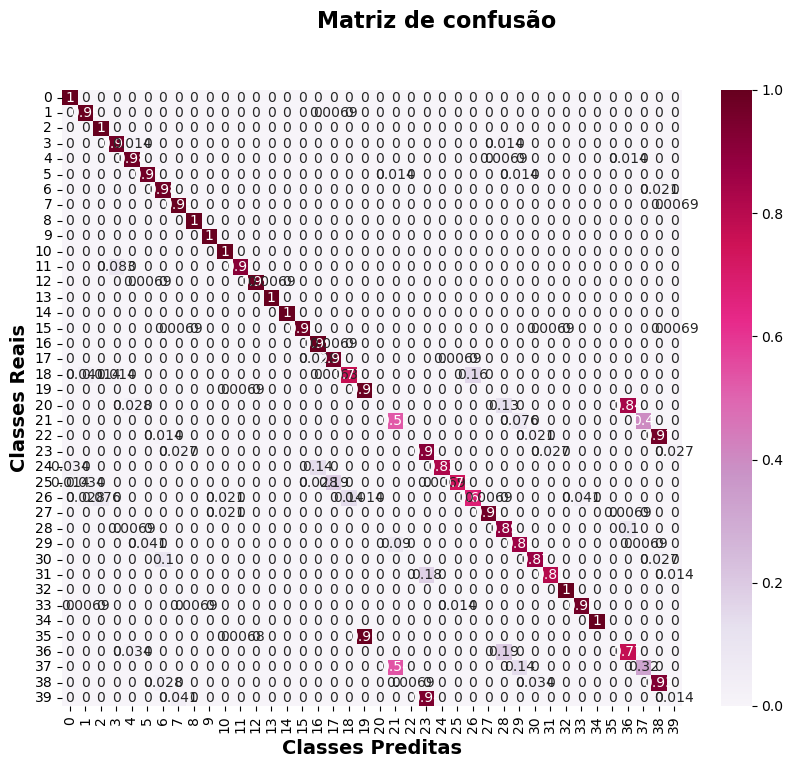

In [11]:
# **Matriz de confusão**
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(avaliado, predito, normalize='true')


fig = plt.figure(figsize=(10,8))
fig.suptitle("Matriz de confusão", fontsize=16, fontweight="bold")

sns.heatmap(cm, cmap="PuRd", annot=True)

plt.xlabel('Classes Preditas', fontsize=14, fontweight="bold")
plt.ylabel('Classes Reais', fontsize=14, fontweight="bold")



plt.savefig("matriz_confusao_USP_real.png", format='png')
plt.plot()

In [12]:
# **Classification Report**

from sklearn.metrics import classification_report

print(classification_report(avaliado, predito))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98       145
         1.0       0.90      0.99      0.94       145
         2.0       0.92      1.00      0.96       146
         3.0       0.91      0.97      0.94       146
         4.0       0.92      0.98      0.95       145
         5.0       0.95      0.97      0.96       145
         6.0       0.87      0.98      0.92       145
         7.0       0.93      0.99      0.96       145
         8.0       0.99      1.00      1.00       145
         9.0       1.00      1.00      1.00       145
        10.0       0.96      1.00      0.98       145
        11.0       0.99      0.92      0.95       145
        12.0       1.00      0.99      0.99       145
        13.0       0.99      1.00      1.00       145
        14.0       1.00      1.00      1.00       145
        15.0       1.00      0.98      0.99       145
        16.0       0.84      0.99      0.91       145
        17.0       0.82    

c:\Users\vinic\.conda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vinic\.conda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vinic\.conda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
